In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install boruta
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from scipy.stats import f_oneway

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


from imblearn.over_sampling import SMOTE

from boruta import BorutaPy
from sklearn.feature_selection import RFECV

In [ ]:
data = pd.read_excel('/content/drive/My Drive/FYP2/FYP2_Data_Final.xlsx')
data.head(2)

### Analytical Dataset

In [ ]:
data = data.drop(columns=['dep_Lat','dep_Lon','arr_Lat','arr_Lon','delayed','flight_iata'])

### Label Encoding

In [ ]:
data_encode = data.copy()
data_encode = data_encode.apply(LabelEncoder().fit_transform)
data_encode.head()

,Airline,dep_City,dep_Airport,dep_Date_utc,dep_Time_utc,dep_Day_utc,dep_Weekend_local,dep_PartofHour_local,arr_City,arr_Airport,...,Arrival_Cloudcover,Arrival_WindSpeed,Arrival_WindDirection,Arrival_WindGusts,Departure_Intensity Level,Departure_Intensity Status,Departure_Busyness,Arrival_Intensity Level,Arrival_Intensity Status,Arrival_Busyness
0,71,1,0,10,144,0,0,1,105,26,...,1,94,357,48,2,1,11,5,5,21
1,14,1,0,10,143,0,0,1,74,150,...,100,54,2,55,2,1,11,2,1,6
2,71,1,0,10,143,0,0,1,42,39,...,2,77,312,36,2,1,11,5,5,21
3,88,1,0,10,143,0,0,1,144,141,...,100,55,352,43,2,1,11,4,3,17
4,92,2,1,10,143,0,0,1,31,31,...,100,200,199,103,4,3,13,2,1,9


### Data Imbalanced Treatment

0    50213
1    10336
Name: delayStatus, dtype: int64


Text(0.5, 1.0, 'Class Distribution')

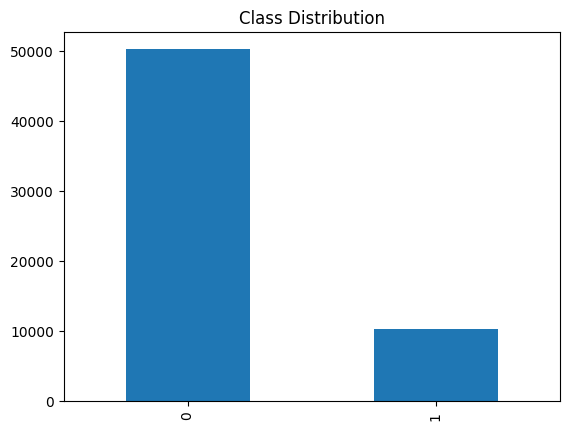

In [ ]:
print(data_encode["delayStatus"].value_counts())
data_encode["delayStatus"].value_counts().plot(kind="bar")
plt.title("Class Distribution")

In [ ]:
smote_X = data_encode.loc[:, data_encode.columns != 'delayStatus']
smote_y = data_encode.loc[:, data_encode.columns == 'delayStatus']

# construct the SMOTE model
os = SMOTE(random_state=42)

# train-test-split with test size 30% and random state=10
X_train, X_test, y_train, y_test = train_test_split(smote_X, smote_y.values.ravel(), test_size = 0.3, random_state=10)
columns = X_train.columns

# fit the smote model with training data only
os_data_X, os_data_y = os.fit_resample(X_train, y_train)

# change to dataframe
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y = pd.DataFrame(data=os_data_y,columns=['delayStatus'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['delayStatus']==0]))
print("Number of subscription",len(os_data_y[os_data_y['delayStatus']==1]))
print("Proportion of No Delay in oversampled data is ",len(os_data_y[os_data_y['delayStatus']==0])/len(os_data_X))
print("Proportion of Delay in oversampled data is ",len(os_data_y[os_data_y['delayStatus']==1])/len(os_data_X))

length of oversampled data is  70336
Number of no subscription in oversampled data 35168
Number of subscription 35168
Proportion of No Delay in oversampled data is  0.5
Proportion of Delay in oversampled data is  0.5


In [ ]:
df_smote = pd.concat([os_data_X, os_data_y], axis=1)
df_smote.head()

,Airline,dep_City,dep_Airport,dep_Date_utc,dep_Time_utc,dep_Day_utc,dep_Weekend_local,dep_PartofHour_local,arr_City,arr_Airport,...,Arrival_WindSpeed,Arrival_WindDirection,Arrival_WindGusts,Departure_Intensity Level,Departure_Intensity Status,Departure_Busyness,Arrival_Intensity Level,Arrival_Intensity Status,Arrival_Busyness,delayStatus
0,7,0,2,38,22,6,0,2,115,59,...,59,350,52,2,1,9,5,5,21,0
1,92,2,1,38,208,6,0,3,97,113,...,29,5,20,1,2,3,5,5,21,0
2,92,2,1,41,61,6,0,0,17,154,...,62,38,51,4,3,14,4,3,18,0
3,39,0,2,57,225,2,1,3,1,16,...,51,67,38,0,4,0,3,0,14,0
4,38,2,1,39,157,5,0,3,44,42,...,109,352,39,2,1,9,2,1,12,0


0    35168
1    35168
Name: delayStatus, dtype: int64


Text(0.5, 1.0, 'Class Distribution')

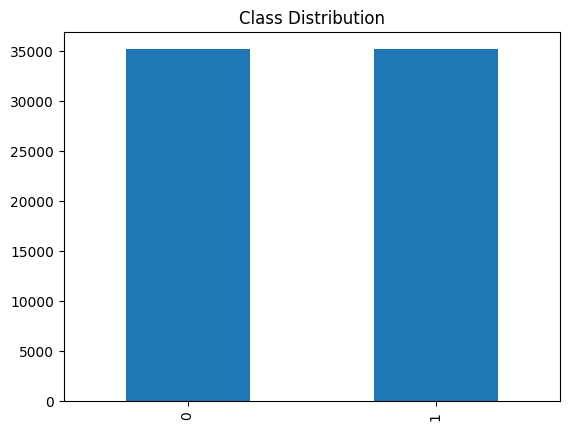

In [ ]:
print(df_smote["delayStatus"].value_counts())
df_smote["delayStatus"].value_counts().plot(kind="bar")
plt.title("Class Distribution")

In [ ]:
nonSmote = data_encode["delayStatus"]
smote = df_smote["delayStatus"]

print('One Way Anova =>',f_oneway(nonSmote,smote))

One Way Anova => F_onewayResult(statistic=17655.67798682672, pvalue=0.0)


### FEATURE SELECTION

In [ ]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

### RFE

In [ ]:
y = data_encode['delayStatus']
X = data_encode.drop('delayStatus', axis = 1)
colnames = X.columns

rf = RandomForestClassifier(n_jobs=-1,class_weight='balanced_subsample',max_depth = 5,n_estimators=20,random_state=1)
rf.fit(X,y)
rfe = RFECV(rf,min_features_to_select = 1, cv=2)
rfe.fit(X,y)

RFECV(cv=2,
      estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                       max_depth=5, n_estimators=20, n_jobs=-1,
                                       random_state=1))

In [ ]:
rfe_score = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)
rfe_score = pd.DataFrame(list(rfe_score.items()), columns=['Features', 'Score'])
rfe_score = rfe_score.sort_values("Score", ascending = False)
rfe_score.reset_index(drop=True, inplace= True)

In [ ]:
print('---------Top 30----------')
display(rfe_score.head(30))

---------Top 30----------


,Features,Score
0,dep_Time_utc,1.00
1,arr_Time_utc,1.00
2,Airline,0.98
3,dep_PartofHour_local,0.96
4,Departure_Temperature,0.93
5,Departure_Busyness,0.91
6,duration,0.89
7,Departure_Humidity,0.87
8,dep_Date_utc,0.85
9,dep_Day_utc,0.83


In [ ]:
print('---------Bottom 30----------')
display(rfe_score.tail(20))

---------Bottom 30----------


,Features,Score
28,Arrival_SeaLevelPressure,0.41
29,Departure_Cloudcover,0.39
30,Arrival_WindGusts,0.37
31,Departure_Intensity Status,0.35
32,Departure_Rain,0.33
33,Arrival_Intensity Status,0.30
34,Arrival_Cloudcover,0.28
35,Arrival_WeatherCode,0.26
36,dep_Weekend_local,0.24
37,arr_Weekend_local,0.22


### MODEL CONSTRUCTION

In [ ]:
from google.colab import files

def model(label,X,y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)
  model = []
  accuracy = []
  precision = []
  recall = []
  f1 = []

  # NB
  nb_clf = GaussianNB()
  nb_clf.fit(X_train, y_train)
  y_pred = nb_clf.predict(X_test)

  acc = round((accuracy_score(y_test, y_pred)*100), 2)
  model.append("Naive Bayes")
  accuracy.append(acc)
  precision.append(precision_score(y_test, y_pred, zero_division=0, average='weighted'))
  recall.append(recall_score(y_test, y_pred, average='weighted'))
  f1.append(f1_score(y_test, y_pred, average='weighted'))
  filename = label+"_nb.pkl"
  with open(filename, 'wb') as file:
    pickle.dump(nb_clf, file)
  files.download(filename)

  #SVM
  svm_clf = svm.SVC()
  svm_clf.fit(X_train, y_train)
  y_pred = svm_clf.predict(X_test)

  acc = round((accuracy_score(y_test, y_pred)*100), 2)
  model.append("Support Vector Machine")
  accuracy.append(acc)
  precision.append(precision_score(y_test, y_pred, zero_division=0, average='weighted'))
  recall.append(recall_score(y_test, y_pred, average='weighted'))
  f1.append(f1_score(y_test, y_pred, average='weighted'))
  filename = label+"_svm.pkl"
  with open(filename, 'wb') as file:
    pickle.dump(svm_clf, file)
  files.download(filename)

  #Decision Tree
  dt_clf = DecisionTreeClassifier()
  dt_clf.fit(X_train, y_train)
  y_pred = dt_clf.predict(X_test)

  acc = round((accuracy_score(y_test, y_pred)*100), 2)
  model.append("Decision Tree")
  accuracy.append(acc)
  precision.append(precision_score(y_test, y_pred, zero_division=0, average='weighted'))
  recall.append(recall_score(y_test, y_pred, average='weighted'))
  f1.append(f1_score(y_test, y_pred, average='weighted'))
  filename = label+"_dt.pkl"
  with open(filename, 'wb') as file:
    pickle.dump(dt_clf, file)
  files.download(filename)

  #Random Forest
  rf_clf = RandomForestClassifier()
  rf_clf.fit(X_train, y_train)
  y_pred = rf_clf.predict(X_test)

  acc = round((accuracy_score(y_test, y_pred)*100), 2)
  model.append("Random Forest")
  accuracy.append(acc)
  precision.append(precision_score(y_test, y_pred, zero_division=0, average='weighted'))
  recall.append(recall_score(y_test, y_pred, average='weighted'))
  f1.append(f1_score(y_test, y_pred, average='weighted'))
  filename = label+"_rf.pkl"
  with open(filename, 'wb') as file:
    pickle.dump(rf_clf, file)
  files.download(filename)

  #K Nearest Neighbours
  knn_clf = KNeighborsClassifier()
  knn_clf.fit(X_train, y_train)
  y_pred = knn_clf.predict(X_test)

  acc = round((accuracy_score(y_test, y_pred)*100), 2)
  model.append("K Nearest Neighbours")
  accuracy.append(acc)
  precision.append(precision_score(y_test, y_pred, zero_division=0, average='weighted'))
  recall.append(recall_score(y_test, y_pred, average='weighted'))
  f1.append(f1_score(y_test, y_pred, average='weighted'))
  filename = label+"_knn.pkl"
  with open(filename, 'wb') as file:
    pickle.dump(knn_clf, file)
  files.download(filename)

  #Logistic Regression
  lg_clf = LogisticRegression()
  lg_clf.fit(X_train, y_train)
  y_pred = lg_clf.predict(X_test)

  acc = round((accuracy_score(y_test, y_pred)*100), 2)
  model.append("Logistic Regression")
  accuracy.append(acc)
  precision.append(precision_score(y_test, y_pred, zero_division=0, average='weighted'))
  recall.append(recall_score(y_test, y_pred, average='weighted'))
  f1.append(f1_score(y_test, y_pred, average='weighted'))

  filename = label+"_lr.pkl"
  with open(filename, 'wb') as file:
    pickle.dump(lg_clf, file)
  files.download(filename)

  return pd.DataFrame({"Model":model,"Accuracy":accuracy,"Precision":precision,"Recall":recall,"F1-score":f1})

### Model Accuracy using normal Data

In [ ]:
y = data_encode['delayStatus']
X = data_encode.drop('delayStatus', axis = 1)
X = X[rfe_score.Features[0:10]].copy()

acc = model("norm10",X,y)
display(acc)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Model,Accuracy,Precision,Recall,F1-score
0,Naive Bayes,83.52,0.806992,0.835233,0.811496
1,Support Vector Machine,84.61,0.821792,0.846078,0.813989
2,Decision Tree,84.58,0.846496,0.845802,0.846145
3,Random Forest,88.35,0.875467,0.883512,0.877242
4,K Nearest Neighbours,85.52,0.841634,0.855216,0.845490
5,Logistic Regression,82.86,0.776946,0.828626,0.770626


In [ ]:
y = data_encode['delayStatus']
X = data_encode.drop('delayStatus', axis = 1)
X = X[rfe_score.Features[0:30]].copy()

acc = model('norm30',X,y)
display(acc)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Model,Accuracy,Precision,Recall,F1-score
0,Naive Bayes,81.90,0.806330,0.818993,0.811720
1,Support Vector Machine,82.93,0.687717,0.829287,0.751896
2,Decision Tree,83.50,0.836907,0.835012,0.835935
3,Random Forest,87.94,0.869408,0.879438,0.870119
4,K Nearest Neighbours,84.42,0.826138,0.844206,0.831017
5,Logistic Regression,83.13,0.788597,0.831269,0.781719


### Model Accuracy using SMOTE Data

In [ ]:
y = df_smote['delayStatus']
X = df_smote.drop('delayStatus', axis = 1)
X = X[rfe_score.Features[0:10]].copy()

acc = model('smote10',X,y)
display(acc)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Model,Accuracy,Precision,Recall,F1-score
0,Naive Bayes,66.75,0.668450,0.667504,0.667038
1,Support Vector Machine,72.36,0.732660,0.723615,0.720904
2,Decision Tree,85.18,0.851772,0.851761,0.851759
3,Random Forest,91.07,0.910673,0.910668,0.910667
4,K Nearest Neighbours,83.25,0.833997,0.832472,0.832281
5,Logistic Regression,67.32,0.676684,0.673238,0.671639


In [ ]:
y = df_smote['delayStatus']
X = df_smote.drop('delayStatus', axis = 1)
X = X[rfe_score.Features[0:30]].copy()

acc = model('smote30',X,y)
display(acc)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Model,Accuracy,Precision,Recall,F1-score
0,Naive Bayes,67.44,0.674834,0.674423,0.674231
1,Support Vector Machine,71.56,0.727214,0.715606,0.711924
2,Decision Tree,86.96,0.869680,0.869580,0.869571
3,Random Forest,93.10,0.931025,0.930999,0.930998
4,K Nearest Neighbours,83.84,0.856351,0.838444,0.836389
5,Logistic Regression,67.35,0.676528,0.673475,0.672055
